# Grouping incidents caused by metheorological events

---
### Notebook Sections:

1. Utility functions
1. Data Cleaning
2. Exploratory Data Analysis
3. Clustering Incidents

### Import modules and functions

In [1]:
import os, pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns; sns.set()
from IPython.display import clear_output as co

### Define data class to host data paths
class DATA:
    path = r'C:\Users\luisr\Desktop\Repositories\Dados\Desafio COR-Rio IV\\'
    AlertaAPI = r'http://websempre.rio.rj.gov.br/json/chuvas'

### Load data

In [2]:
catalog = pd.read_csv('dados/incident_catalog.csv', parse_dates=True, infer_datetime_format=True)

#### Extract records of incidents of water bag formation (copy data for cleaning)

In [3]:
catalog = catalog[catalog['POP_TITULO']=="Bolsão d'água em via"].copy()
data = catalog.copy()

---
## 0. Utility functions

#### Function to format and correct street number text variable

In [4]:
from text_formatter import text_transform_pipeline, get_not_number, drop_letters, drop_space, drop_chars, split_avg

#### Plot colored and connected coordinates in 2D plane

In [5]:
cmaps = [
    'Pastel1', 'Pastel2', 'Paired', 'Accent',
    'Dark2', 'Set1', 'Set2', 'Set3',
    'tab10', 'tab20', 'tab20b', 'tab20c'
]

from sklearn.preprocessing import LabelEncoder as le

def scatter_cordinates_colored(lat, lng, groups, cmap=None, title='', figsize=None):
    cMap = plt.get_cmap(cmap) if cmap else None
    labels = pd.Series(le().fit_transform(groups), index=groups.index)
    plt.figure(figsize=figsize)
    for label in labels.unique():
        msk = labels==label
        plt.scatter(lat[msk], lng[msk], c=(cMap(label) if cmap else None), cmap=cMap)
    plt.xlabel('Latitude'); plt.ylabel('Longitude'); plt.title(title); plt.show()

def connect_cordinates_colored(lat, lng, groups, numbers, cmap='tab10', title='', figsize=None):
    cmap = plt.get_cmap(cmap)
    labels = pd.Series(le().fit_transform(groups), index=groups.index)
    plt.figure(figsize=figsize)
    for label in labels.unique():
        group_index = numbers[labels==label].sort_values().index
        group_lat, group_lng = lat.loc[group_index], lng.loc[group_index]
        plt.plot(group_lat, group_lng)
        plt.scatter(group_lat, group_lng, s=30)
    plt.xlabel('Latitude'); plt.ylabel('Longitude'); plt.title(title); plt.show()

def min_group_size_progression_plot(data, coord_cols, group_col, max_incidents=15, color='blue', figsize=None, pause=0.3):
    route_count = data[group_col].value_counts(); recurrence = []
    for min_incidents in range(max_incidents+1):
        rec_routes = route_count[route_count>=min_incidents]
        rec_data = data[data[group_col].isin(rec_routes.index)]
        n_routes = len(rec_routes)
        n_incidents = rec_data.shape[0]
        p_routes = round(n_routes / route_count.shape[0] * 100, 1)
        p_incidents = round(n_incidents / data.shape[0] * 100, 1)
        recurrence.append([min_incidents, n_routes, n_incidents, p_routes, p_incidents])
        fig = plt.figure(figsize=figsize); ax = fig.add_subplot(111)
        rec_data.plot(
            coord_cols[0], coord_cols[1],
            kind='scatter', c=color, ax=ax,
            title=f'''Min Incidents per Route: {min_incidents} / {max_incidents}.
Routes: {n_routes} / {route_count.shape[0]} ({p_routes} %). Incidents: {n_incidents} / {data.shape[0]} ({p_incidents} %)''',
        )
        plt.show(); plt.pause(pause); co(wait=True)
    return pd.DataFrame(recurrence, columns=['min_incidents', 'n_routes', 'n_incidents', 'p_routes (%)', 'p_incidents (%)']); # recurrence_df

def atemporal_evolution_plot(
    data, coord_cols=['lat', 'lng'], time_col='evento_inicio', color='blue',
    group_col='route', min_per_group=15, cmap=None, lut=None,
    pause=0.3, frame_evolution=25, freq='D',
    figsize=(9, 5), title='Progess: {} / {}',
    path=None,

):
    data_left = data.sort_values(time_col).copy()
    color_code=None

    if group_col is not None:
        if min_per_group is not None: # filter data by groups with at least 'min_per_group' members
            group_count = data[group_col].value_counts()
            groups_left = group_count[group_count>=min_per_group]
            data_left = data[data[group_col].isin(groups_left.index)].copy()
        color_code = pd.Series(le().fit_transform(data_left[group_col]), index=data_left.index).map(plt.get_cmap(cmap, lut=lut))

    n_samples = len(data_left)
    
    if freq is None:
        print_frames = data_left.index[range(0, n_samples+1, frame_evolution)]
    else:
        ts_values = pd.to_datetime(data_left[time_col])
        data_left[time_col] = ts_values
        if group_col is not None:
            color_code.index = ts_values
            color_code.sort_index(inplace=True)
        data_left.set_index(time_col, inplace=True)
        data_left.sort_index(inplace=True)
        ts = data_left.index
        print_frames = pd.date_range(ts.min(), ts.max(), freq=freq)

    coord_data = data_left[coord_cols]
    for index in print_frames:
        
        frame_data = coord_data.loc[:index]
            
        if group_col is not None:
            c = color_code.loc[:index]
            clr = None
        else:
            c = color
            clr = color
            
        if freq is not None:
            date, time = str(index).split()
            Title = title.format(date, time)
        else:
            Title = title.format(len(frame_data), n_samples)
            
        fig = plt.figure(figsize=figsize); ax = fig.add_subplot(111)
        frame_data.plot(
            coord_cols[0], coord_cols[1],
            kind='scatter',
            c=c,
            title=Title,
            ax=ax,
#             color=clr
        )
        if path is not None: plt.savefig(path.format(date if freq else index))
        plt.show(); plt.pause(pause); co(wait=True)


---
# 1. Data Cleaning

In [6]:
data.head()

,EVENTO_ID,EVENTO_TITULO,EVENTO_DESCRICAO,EVENTO_GRAVIDADE,EVENTO_BAIRRO,STATUS,EVENTO_PRAZO,POP_TITULO,POP_DESCRICAO,evento_inicio,...,formatted_address,place_id,types,search_lat,search_lng,location_type,route,street_number,postal_code,premise
12,1258,Bolsão d'agua,R. Pinheiro Machado com Muniz Barreto - Botafogo,BAIXO,NaN,FECHADO,NaN,Bolsão d'água em via,Bolsão d'água em via,2015-09-12 20:12:00,...,"R. Muniz Barreto, 366 - Botafogo, Rio de Janei...",ChIJi27zffJ_mQARL55umyJIS4Q,['street_address'],-22.944790,-43.184068,ROOFTOP,Rua Muniz Barreto,366,22251-090,NaN
13,1259,Bolsão,"Av. Novo Rio, 3131 - Bonsucesso",BAIXO,NaN,FECHADO,NaN,Bolsão d'água em via,Bolsão d'água em via,2015-09-12 22:13:00,...,"Av. Novo Rio, 3131 - Bonsucesso, Rio de Janeir...",ChIJ-wBnkRx8mQARRqlXSftw2ds,['premise'],-22.871948,-43.256108,ROOFTOP,Avenida Novo Rio,3131,21051-051,NaN
14,1260,Bolsão,"Av. Ataulfo de Paiva, 752 - Leblon",BAIXO,NaN,FECHADO,NaN,Bolsão d'água em via,Bolsão d'água em via,2015-09-12 22:15:00,...,"Av. Ataulfo de Paiva, 750 - Leblon, Rio de Jan...",ChIJg668f63VmwARDiaRGOdZ--I,['street_address'],-22.984207,-43.223015,ROOFTOP,Avenida Ataulfo de Paiva,750,22440-033,NaN
15,1261,Bolsão,Avenida General San Martin / Praça Antero de Q...,BAIXO,NaN,FECHADO,NaN,Bolsão d'água em via,Bolsão d'água em via,2015-09-12 22:16:00,...,"Av. Ataulfo de Paiva, 750 - Leblon, Rio de Jan...",ChIJg668f63VmwARDiaRGOdZ--I,['street_address'],-22.984207,-43.223015,ROOFTOP,Avenida Ataulfo de Paiva,750,22440-033,NaN
16,1263,Bolsão d'água,"Av. Brasil, 40 - São Cristóvão",BAIXO,NaN,FECHADO,NaN,Bolsão d'água em via,Bolsão d'água em via,2015-09-13 06:30:00,...,"Av. Brasil, 35 - São Cristóvão, Rio de Janeiro...",ChIJCeABSN5-mQAR6RjL3C-eriQ,['street_address'],-22.892142,-43.216479,ROOFTOP,Avenida Brasil,35,NaN,NaN


#### Format and correct street number variable

In [7]:
not_number = get_not_number(catalog['street_number'])

not_number_corrected =  text_transform_pipeline(not_number, [drop_letters, drop_space, drop_chars, split_avg])

data.loc[not_number.index, ['street_number']] = not_number_corrected

data.dropna(subset=['street_number'], inplace=True) # drop rows where street number is missing

#### Data type conversion

In [8]:
float_cols = ['lat', 'lng', 'search_lat', 'search_lng', 'street_number']
data[float_cols] = data[float_cols].astype(float)

---
# 2. Exploratory Data Analysis

### 1. Coordinades visualization

#### Scatter plot of original coordinates

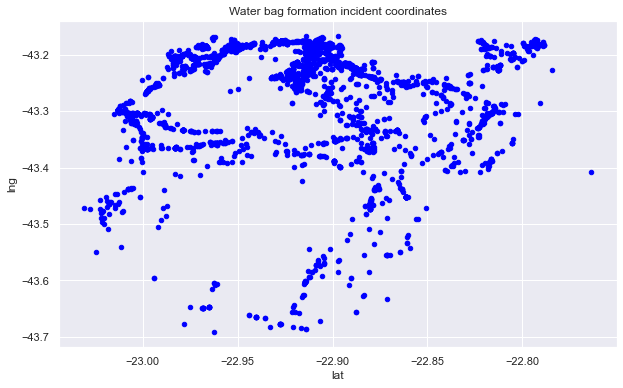

In [9]:
data.plot(
    'lat', 'lng', kind='scatter',
    c='blue', figsize=(10, 6),
    title='Water bag formation incident coordinates'
); plt.show()

### 2. Incidents per rout

#### Incidents per route - top 15

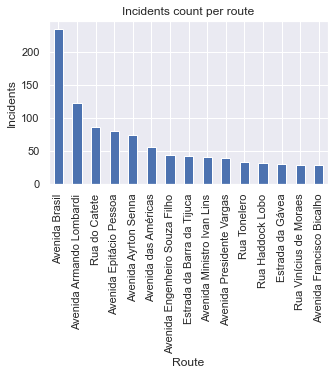

In [10]:
route_count = data['route'].value_counts().rename('Incident Count')
fig, ax = plt.subplots(figsize=(5, 3))
route_count.head(15).plot.bar(
    title='Incidents count per route',
)
ax.set(
    ylabel='Incidents',
    xlabel='Route'
)
plt.show()

#### Excluding routes with less than dinamic 'min_incidents' - Animation

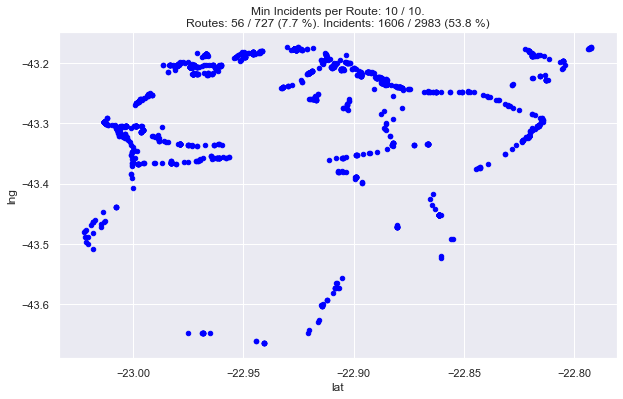

In [11]:
recurrence = min_group_size_progression_plot(
    data, ['lat', 'lng'], 'route',
    max_incidents=10, pause=0.5,
    figsize=(10, 6), color='blue'
)

#### Percentage of routes and incidents left in routes where min incidents is 8

In [15]:
min_incidents = 7; recurrence[recurrence['min_incidents']>=min_incidents]

NameError: name 'recurrence' is not defined

#### Extracting incidents of top 50 routes

In [16]:
rec_routes = route_count[route_count >= min_incidents]
rec_data = data[data['route'].isin(rec_routes.index)]
rec_routes.tail()

Rua Camerino                            7
Rua Ministro Raul Machado               7
Rua Doutor Satamini                     7
Estrada do Joá                          7
Via Expressa Presidente João Goulart    7
Name: Incident Count, dtype: int64

### 3. Routes Visualization 

#### Scatter plot of coordinates colored by routes

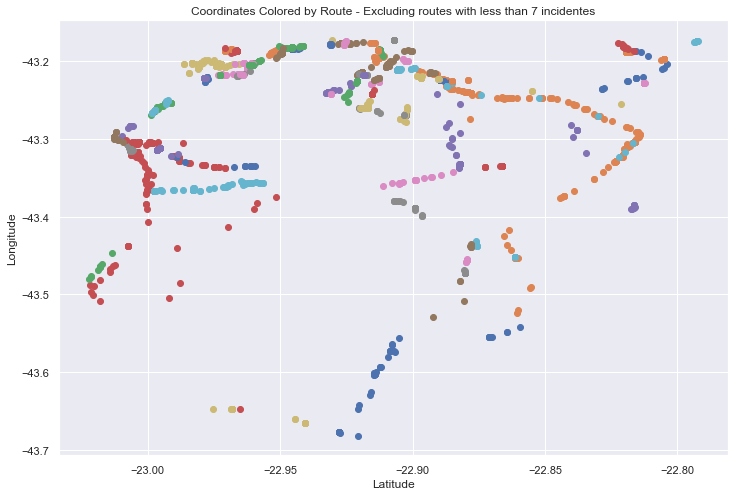

In [17]:
scatter_cordinates_colored(
    rec_data['lat'], rec_data['lng'], rec_data['route'], #cmap='tab10',
    title=f'Coordinates Colored by Route - Excluding routes with less than {min_incidents} incidentes',
    figsize=(12, 8)
)

#### Line & Scatter plot of coordinates (colored by route and connected by address street number order)

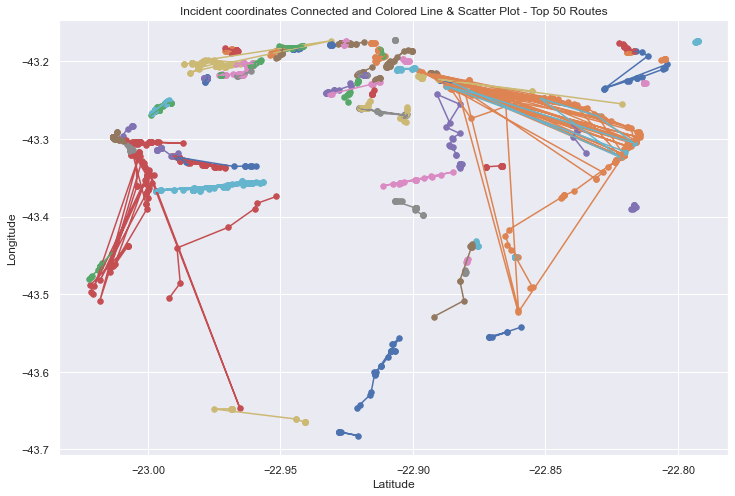

In [18]:
connect_cordinates_colored(
    rec_data['search_lat'], rec_data['search_lng'],
    rec_data['route'], rec_data['street_number'], cmap=None,
    title='Incident coordinates Connected and Colored Line & Scatter Plot - Top 50 Routes',
    figsize=(12, 8)
)

Obs: Street number order for records in the same route is not matching for some specific big routes.

### 4. Route and street number statistical analysis 

#### Street numbers statistical description per route (top 10)

In [19]:
number_desc = data.groupby('route')['street_number'].describe().sort_values('count', ascending=False)
number_desc.head(10)

,count,mean,std,min,25%,50%,75%,max
route,,,,,,,,
Avenida Brasil,235.0,4914.454745,8170.248330,13.0,211.0,500.0,5420.00,35025.0
Avenida Armando Lombardi,123.0,339.861789,430.901577,33.0,188.0,188.0,350.00,3652.0
Rua do Catete,87.0,175.724138,55.524285,1.0,139.0,195.0,228.00,228.0
Avenida Epitácio Pessoa,81.0,1629.308642,1413.060178,5.0,165.0,1612.0,2690.00,4800.0
Avenida Ayrton Senna,74.0,2434.189189,2388.383282,80.0,300.0,2400.0,4581.75,9001.0
Avenida das Américas,57.0,5079.501754,6514.539946,12.3,801.0,2250.0,4444.00,20035.0
Avenida Engenheiro Souza Filho,44.0,1374.454545,801.623018,10.0,586.5,1190.0,2100.00,2631.0
Estrada da Barra da Tijuca,43.0,1426.906977,634.024103,186.0,1030.0,1636.0,1716.00,3163.0
Avenida Ministro Ivan Lins,41.0,749.097561,354.292662,11.0,740.0,850.0,850.00,1770.0


#### Routes' street number range statistical description

In [20]:
number_range = ( number_desc['max'] - number_desc['min'] ).rename('Street Number Range')
number_range.describe()

count      727.000000
mean       614.483398
std       2645.060878
min          0.000000
25%          0.000000
50%          0.000000
75%        139.000000
max      35012.000000
Name: Street Number Range, dtype: float64

Obs: Street number range has good potential to segment routes

#### Routes' street number range percentiles

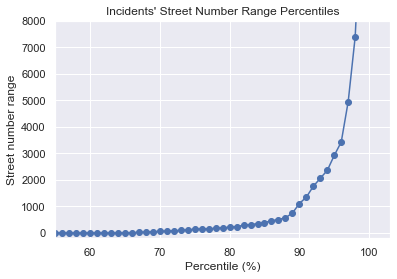

In [21]:
prcts = range(0, 101, 1)
percentiles = pd.Series(np.percentile(number_range, prcts), index=prcts)
plt.plot(percentiles, marker='o')
plt.title("Incidents' Street Number Range Percentiles")
plt.xlabel('Percentile (%)')
plt.ylabel("Street number range")
plt.xlim((55, 103))
plt.ylim((-200, 8000))
plt.show()

Obs: Street number ranges are distributed uniformly along three natural intervals. This means there are three major scales to classify streets by street number ranges of formation of water bags.


In [22]:
bins = [600, 4000]

#### Linear incident density per route - incidents per 10 m (Top 10 excluding routes with number range less than 10 meters)

In [23]:
route_numbers_density = ( route_count / number_range * 10 ).sort_values(ascending=False).rename('Incidents per 10 m')
density = pd.concat([route_numbers_density, route_count, number_range], 1); density[number_range>=7].head(10)

<ipython-input-23-fef8f96ee413>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  density = pd.concat([route_numbers_density, route_count, number_range], 1); density[number_range>=7].head(10)


,Incidents per 10 m,Incident Count,Street Number Range
Avenida Heitor Beltrão,8.000000,8,10.0
Rua do Rezende,4.666667,7,15.0
Rua José do Patrocínio,4.285714,3,7.0
Rua do Catete,3.832599,87,227.0
Rua do Passeio,3.076923,4,13.0
Avenida Professor Pereira Reis,3.000000,3,10.0
Rua da Lapa,3.000000,3,10.0
Estrada da Cancela Preta,2.857143,24,84.0
Rua Gago Coutinho,2.777778,5,18.0
Rua Leonor Pôrto,2.500000,3,12.0


c:\Users\luisr\anaconda3\lib\site-packages\numpy\lib\function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


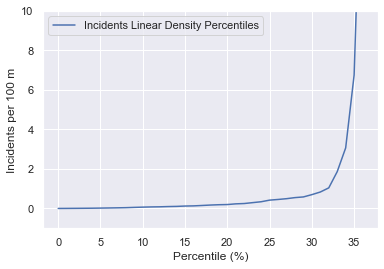

In [19]:
ax = pd.Series(np.percentile(density.iloc[:, 0], range(101)), name='Incidents Linear Density Percentiles').to_frame().plot(
    ylim=(-1, 10)
)
ax.set(ylabel='Incidents per 100 m', xlabel='Percentile (%)'), 
plt.show()

Obs: The linear density division here is below and above 10 incidents per 100 meters. Routes with more than 10 incidents per 100 meter have incidents concentrated in very small regions.

### 5. Incidents time evolution

#### Convert event start and end dates and times to 'datetime64' type

In [24]:
file_path = 'Plots/Animations/Water Bag Formation Time Evolution JPG'
filename = '/frame_{}.jpg'

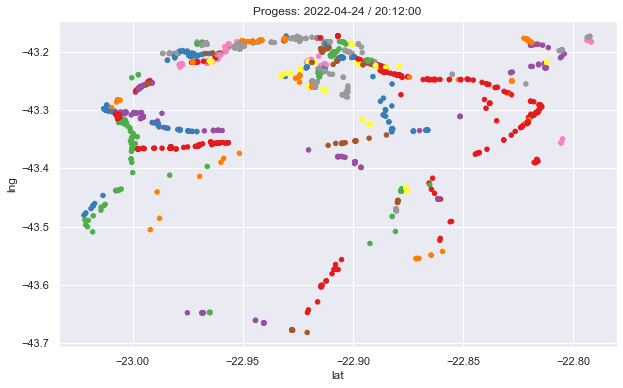

In [182]:
atemporal_evolution_plot(
    data, coord_cols=['lat', 'lng'],
    time_col='evento_inicio', color='blue',
    group_col='route', min_per_group=5,
    cmap='Set1', lut=100,
    pause=.1, frame_evolution=25, freq='W',
    figsize=(10,6), path=file_path+filename
)

#### Save animation ass giff

In [25]:
from gif_builder import folder_to_gif_stream

In [ ]:
gif_path = 'Plots/Animations/Water Bag Time Evolution.gif'

folder_to_gif_stream(file_path, gif_path, duration=0.3)

---
# 3.Clustering Incidents

##### Planning:
1. Cluster all points together
2. Cluster by street number
3. Cluster only routes with more than min_incidents
4. Cluster only routes with more than min_incident_density
5. Cluster only routes with number range above min_street_number_range

#### Setting automatic clustering algorithms

In [172]:
import sklearn.cluster as cluster
from sklearn.preprocessing import MinMaxScaler as mms, LabelEncoder as le

dbscan = cluster.DBSCAN(eps=0.02, min_samples=3)
optics = cluster.OPTICS(min_samples=3, max_eps=0.05)
mean = cluster.MeanShift(bandwidth=0.025, cluster_all=False, max_iter=1000)
aff = cluster.AffinityPropagation(damping=.9, max_iter=1000, random_state=0)

algs = [dbscan, optics, mean, aff]

In [ ]:
a = algs[3]
a?

### 1. Clustering by geodetic coordinates

##### Fit different algorithms

In [179]:
coords = mms().fit_transform(data[['lat', 'lng']])
for alg in algs[:]:
    alg.fit(coords)

c:\Users\luisr\anaconda3\lib\site-packages\sklearn\cluster\_optics.py:803: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


##### Cluster algorithm comparison

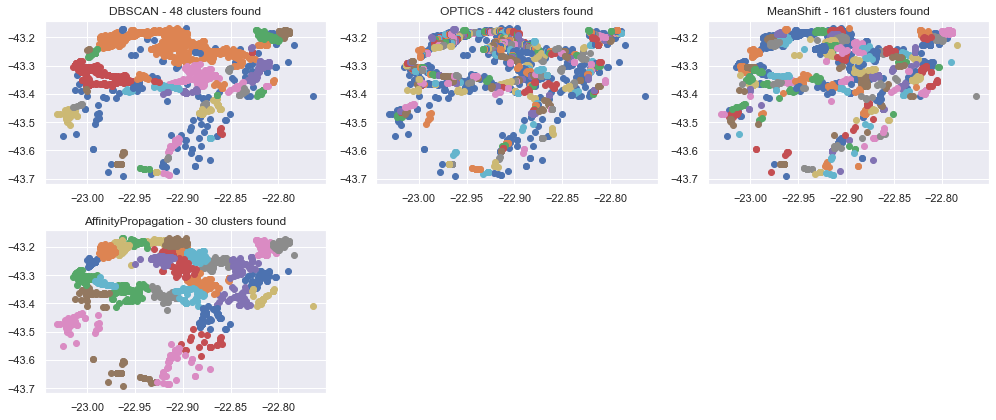

In [180]:
fig = plt.figure(figsize=(14, 6), tight_layout=True)
axs = [fig.add_subplot(2, 3, i) for i in range(1, len(algs)+1)]
for ax, alg in zip(axs, algs):
    for label in np.unique(alg.labels_):
        msk = alg.labels_==label
        ax.scatter(data['lat'][msk], data['lng'][msk]) #, c=alg.labels_)
    ax.set(title=f'{type(alg).__name__} - {len(np.unique(alg.labels_))} clusters found')
plt.show()

#### Best auto algorithm

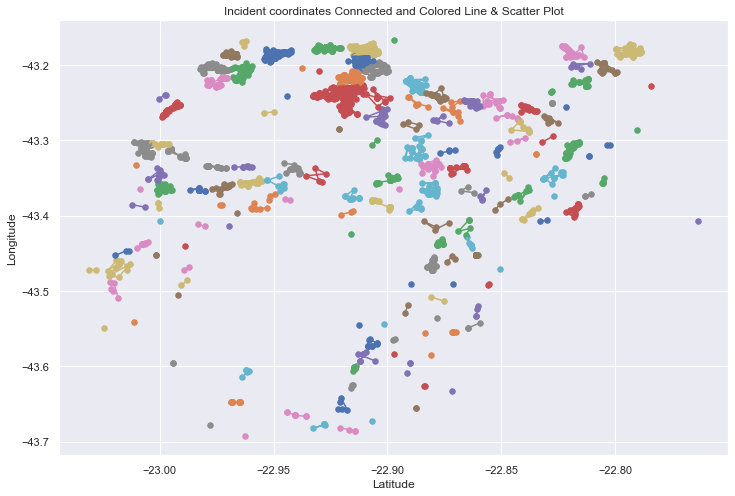

In [178]:
outlier_msk = algs[2].labels_ != -1
connect_cordinates_colored(
    data['lat'][outlier_msk], data['lng'][outlier_msk],
    pd.Series(algs[2].labels_[outlier_msk], index=data.index[outlier_msk]), data['street_number'][outlier_msk], cmap=None,
    title='Incident coordinates Connected and Colored Line & Scatter Plot',
    figsize=(12, 8)
)

### 2. Clustering by street number per route

#### Clustering street numbers of routes separatelly

##### Fit different algorithms

In [38]:
route_numbers = {}
for route in rec_routes.index:
    route_numbers[route] = rec_data.loc[rec_data['route']==route, ['street_number']].dropna().values.tolist()

numbers = mms().fit_transform(route_numbers[route_count.index[0]])
for alg in algs:
    alg.fit(numbers)

c:\Users\luisr\anaconda3\lib\site-packages\sklearn\cluster\_optics.py:803: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


##### Cluster algorithm comparison

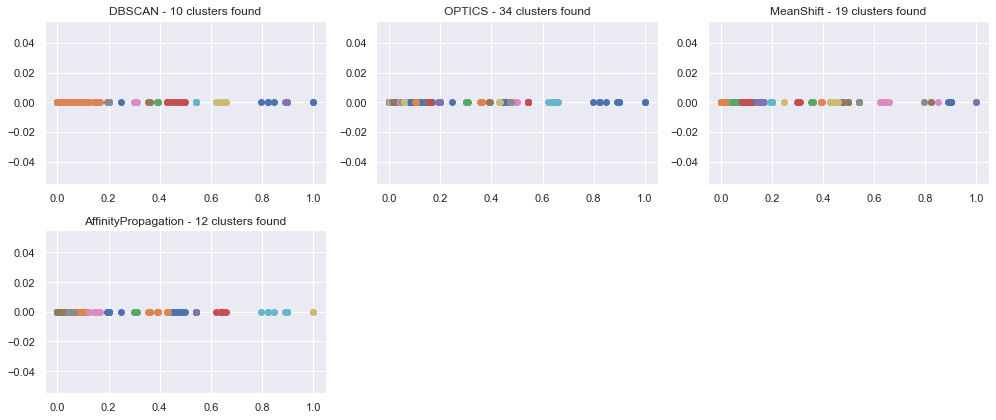

In [39]:
fig = plt.figure(figsize=(14, 6), tight_layout=True)
axs = [fig.add_subplot(2, 3, i) for i in range(1, len(algs)+1)]
for ax, alg in zip(axs, algs):
    for label in np.unique(alg.labels_):
        msk = alg.labels_==label
        ax.scatter(numbers[msk], np.zeros(sum(msk))) #, c=alg.labels_, cmap='tab10')
    ax.set(title=f'{type(alg).__name__} - {len(np.unique(alg.labels_))} clusters found')
plt.show()

Obs: Probably invalid for some routes with deffects in data of street number values

### 3. Only cluster incidents on routes longer than 1 Km

In [ ]:
Obs: Limit incidents by 

In [40]:
up_1000 = number_ranges[number_ranges>2500].index
msk_1000 = rec_data['route'].isin(up_1000)

In [41]:
coords = mms().fit_transform(rec_data[msk_1000][['lat', 'lng']])
for alg in algs[:4]:
    alg.fit(coords)

c:\Users\luisr\anaconda3\lib\site-packages\sklearn\cluster\_optics.py:803: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
c:\Users\luisr\anaconda3\lib\site-packages\sklearn\cluster\_affinity_propagation.py:246: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  warnings.warn("Affinity propagation did not converge, this model "


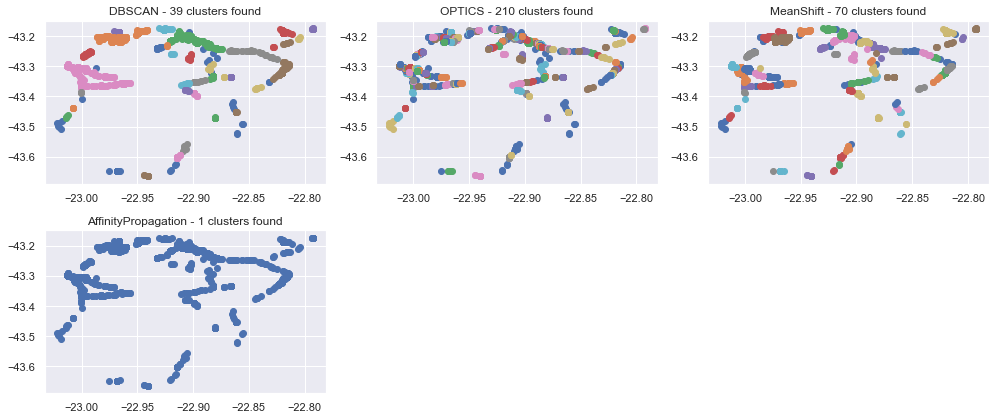

In [42]:
fig = plt.figure(figsize=(14, 6), tight_layout=True)
axs = [fig.add_subplot(2, 3, i) for i in range(1, len(algs)+1)]
for ax, alg in zip(axs, algs):
    for label in np.unique(alg.labels_):
        msk = alg.labels_==label
        ax.scatter(rec_data['lat'][msk_1000][msk], rec_data['lng'][msk_1000][msk]) #, c=alg.labels_)
    ax.set(title=f'{type(alg).__name__} - {len(np.unique(alg.labels_))} clusters found')
plt.show()

### 4. Visualize clusters in folium map

In [43]:
import folium

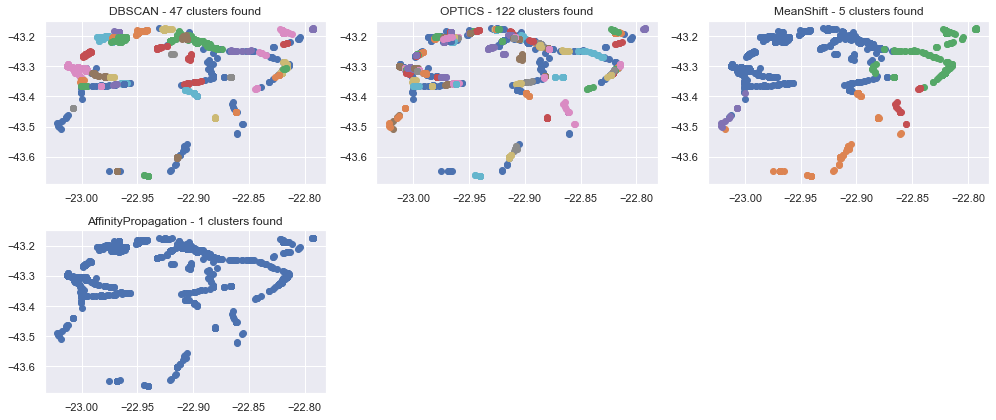

In [64]:
def plot_markers(
    df, center=[-22.9037, -43.4276], zoom=10,
    radius=3, colors=colors,
    exclude=["Bolsão d'água em via"],
    touch_coord=True
):

    m = folium.Map(location=center, zoom_start=zoom, width='80%', height='80%')

    for index in df.index:
        event = df.loc[index]; coord = event.loc[['lat', 'lng']]
        event_type = event['POP_TITULO']
        valid_coord = event_type not in exclude and coord.isna().sum()==0 and not coord.isin(incomplete_values).any()
        if valid_coord:
            folium.CircleMarker(
                location=list(coord), radius=radius,
                color=colors[event_type], opacity=1,
                fill=True, fill_color=colors[event_type],
                fill_opacity=1,
            ).add_to(m)

    if touch_coord: m.add_child(folium.LatLngPopup())
    return m
